# file loading

In [1]:
import requests
import zipfile
import io

# 구글 드라이브 공유 링크에서 파일 ID를 가져옵니다.
file_id = '1ZUueEhjvhzmo8UpZLwqMgzMKA6FGtLJk'  # 여기에 파일 ID를 입력하세요.
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# 파일 다운로드
response = requests.get(download_url)
response.raise_for_status()  # 요청이 실패하면 예외를 발생시킵니다.

# 다운로드한 ZIP 파일을 메모리에서 직접 압축 해제합니다.
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall('/content/unzipped_folder')

# 결과 확인
import os
os.listdir('/content/unzipped_folder')


['test.csv', 'train.csv', 'sample_submission.csv']

# data loading

In [2]:
import pandas as pd
import numpy as np

In [69]:
# 데이터 불러오기
#df = pd.read_csv("/content/unzipped_folder/train.csv")
train = pd.read_csv("/content/unzipped_folder/train.csv")
test = pd.read_csv("/content/unzipped_folder/test.csv")

In [70]:
print(train.head(), train.tail())
print(test.head(), test.tail())

           ID SUBCLASS    A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0  TRAIN_0000    KIPAN     WT   WT    WT    WT   WT    WT    WT    WT  ...   
1  TRAIN_0001     SARC     WT   WT    WT    WT   WT    WT    WT    WT  ...   
2  TRAIN_0002     SKCM  R895R   WT    WT    WT   WT    WT    WT    WT  ...   
3  TRAIN_0003     KIRC     WT   WT    WT    WT   WT    WT    WT    WT  ...   
4  TRAIN_0004   GBMLGG     WT   WT    WT    WT   WT    WT    WT    WT  ...   

  ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10 ZWINT ZYX  
0     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
1     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
2     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
3     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  
4     WT     WT     WT     WT    WT    WT   WT   WT    WT  WT  

[5 rows x 4386 columns]               ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
6196  TRAIN_6196     LUAD  WT   WT    WT    

# preprocessing

## NaN 값 처리

In [71]:
# NaN 개수와 위치 확인
train_nan = train.isna().sum().sum()
train_nan_columns = train.columns[train.isna().any()].tolist()
print(f"train NaN 개수: {train_nan}")
print("NaN 값이 있는 열:")
print(train_nan_columns)

test_nan = test.isna().sum().sum()
test_nan_columns = test.columns[test.isna().any()].tolist()
print(f"test NaN 개수: {test_nan}")
print("NaN 값이 있는 열:")
print(test_nan_columns)

# NaN 값을 'WT'로 치환
train.fillna('WT', inplace=True)
test.fillna('WT', inplace=True)

print()

train_nan = train.isna().sum().sum()
print(f"처리 후 train NaN 개수: {train_nan}")

test_nan = test.isna().sum().sum()
print(f"처리 후 test NaN 개수: {test_nan}")

train NaN 개수: 0
NaN 값이 있는 열:
[]
test NaN 개수: 237
NaN 값이 있는 열:
['AK2', 'ATP6V1H', 'CCRL2', 'CFP', 'CNOT2', 'CRAT', 'DPYSL4', 'GUK1', 'IER3', 'INHBB', 'KCNH1', 'MYL1', 'NDUFV1', 'NUDT4', 'POLD2', 'PTCH1', 'PTGES3', 'RBM5', 'SCAMP1', 'SCNN1A', 'SLC25A28', 'SYBU', 'TARS1', 'TMEM97', 'TNFAIP6']

처리 후 train NaN 개수: 0
처리 후 test NaN 개수: 0


## 아미노산 변이 전처리
R385R과 같은 변이는 WT로 변환

In [72]:
import pandas as pd
import re

# 패턴을 구분하는 함수 정의
def process_value(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    # 2) 복합 패턴 처리를 위한 split
    parts = value.split()  # 공백 기준
    processed_parts = []

    for part in parts:
        # 숫자 앞뒤로 같은 패턴이 있는지 확인
        match = re.match(r'([^\d]+)(\d+)([^\d]+)', part)
        if match:
            prefix, number, suffix = match.groups()
            # 앞뒤 문자가 같다면 해당 부분 무시
            if prefix == suffix and prefix != 'fs':
                continue

            # 유니크한 접두사와 접미사를 추가
            alphabets_p.append(prefix)  # 접두사 추가
            alphabets_s.append(suffix)  # 접미사 추가


            if len(prefix)>1:
                toolong.append(part)
                toolong_pre.append(prefix)
                toolong_suf.append(suffix)

        else:
            # 패턴이 없다면 그대로 추가
            mismatch.append(part)

        processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [73]:
# R385R 형식에 매칭되지 않는 것 확인
mismatch = []

# 접두사 접미사의 알파벳이 아미노산 기호가 맞는지 확인
alphabets_p = []
alphabets_s = []

# 접두사 접미사가 긴 변이 확인
toolong = []
toolong_pre = []
toolong_suf = []

# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value)

# 최종 데이터 확인
print(train)

              ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10  ZWINT Z

### 접두사, 접미사 확인

In [74]:
# 유니크한 값만 남기기
alphabets_p = list(set(alphabets_p))
alphabets_s = list(set(alphabets_s))

# 유니크한 값을 저장할 집합
unique_pre = set()
unique_suf = set()
"""
for item in alphabets_p:
    if item.isupper():  # 대문자로만 구성된 경우
        unique_pre.update(item)  # 개별 문자로 유니크한 값 추가
    else:
        unique_pre.add(item)

for item in alphabets_s:
    if item.isupper():  # 대문자로만 구성된 경우
        unique_suf.update(item)  # 개별 문자로 유니크한 값 추가
    else:
        unique_suf.add(item)
"""

# 결과 출력
print("unique prefix: ", sorted(alphabets_p))
print("unique suffix: ", sorted(alphabets_s))

unique prefix:  ['*', '-', 'A', 'AAPTP', 'AAV', 'AD', 'ADAQG', 'ADLQL', 'AE', 'AEEESCSPSV', 'AF', 'AG', 'AGV', 'AHQA', 'AHT', 'AK', 'AKR', 'AKSIS', 'AL', 'ALEEG', 'ALLPSFSTFAS', 'ALWKLPC', 'AMA', 'AN', 'ANKL', 'AP', 'APAL', 'APM', 'AQ', 'AR', 'ARF', 'ARKGEKPC', 'ARQH', 'AS', 'ASLVS', 'ATD', 'ATTTAPSL', 'AVCTKAGKAIVSR', 'AVH', 'AVLALL', 'AVLNN', 'AVYTL', 'C', 'CAKALTLR', 'CCQDNITA', 'CD', 'CE', 'CF', 'CG', 'CL', 'CP', 'CPV', 'CQ', 'CS', 'D', 'DAEM', 'DC', 'DDGEYNPTD', 'DE', 'DEKIINI', 'DF', 'DFVC', 'DG', 'DGLWSF', 'DHNPPQ', 'DI', 'DIEQWF', 'DK', 'DKKAH', 'DKL', 'DL', 'DLFYNIA', 'DNSILW', 'DP', 'DQ', 'DQLQAQ', 'DQWEDLTPLTFGV', 'DR', 'DRR', 'DS', 'DSGEDRD', 'DSSHV', 'DV', 'DVLGCV', 'DVV', 'DWLSLLL', 'DY', 'E', 'EA', 'EC', 'ECLN', 'ED', 'EE', 'EED', 'EEKTLREQ', 'EETS', 'EG', 'EGENG', 'EI', 'EK', 'EKEAVSP', 'EL', 'ELK', 'ELNQ', 'ELPQ', 'EM', 'ENSS', 'EP', 'EPNC', 'EPQI', 'EQ', 'ER', 'EREDSAAE', 'ES', 'ESA', 'ET', 'EV', 'EVT', 'EVYLV', 'EWI', 'F', 'FAILIIQ', 'FAN', 'FD', 'FFLV', 'FFSGR', 'FG

In [75]:
toolong = list(set(toolong))

print("toolong: ", toolong)

toolong:  ['GP421fs', 'LN563fs', 'DP198fs', 'NK120fs', 'GGRMEGP222fs', 'QPL393fs', 'YF336fs', 'EWI927fs', 'PTPMTLAAP489fs', 'KV352fs', 'VL144fs', 'ALWKLPC210fs', 'VF177fs', 'QT700fs', 'TAP91fs', 'RE1066fs', 'SWPL90fs', 'AP122fs', 'RLCEEMTGQCRC1317fs', 'LLDSP219fs', 'KL1041fs', 'RCQER1400fs', 'TL141fs', 'RN135fs', 'RG301fs', 'RSK786fs', 'KE250fs', 'KM132fs', 'CG342fs', 'PG45fs', 'EPNC69fs', 'LQK110fs', 'PR33fs', 'GAA28fs', 'VRQ753fs', 'LWLF116fs', 'RV120fs', 'NFI1133fs', 'MAM451fs', 'DP393fs', 'PVL61fs', 'NL73fs', 'EL350fs', 'DG60fs', 'AG615fs', 'QCE513fs', 'DSGEDRD274fs', 'YG338fs', 'PATPLC242fs', 'AP27fs', 'FD91fs', 'YSH810fs', 'EE572fs', 'GE47fs', 'GCAQPN247fs', 'YV127fs', 'AHT396fs', 'SF477fs', 'YQLEG182fs', 'YR343fs', 'FLC11fs', 'HMTEV168fs', 'RR364fs', 'EETS284fs', 'GK223fs', 'NK33fs', 'SRVD510fs', 'TK4114fs', 'PK725fs', 'RG227fs', 'VD469fs', 'RLLR718fs', 'CG124fs', 'GYAIVR36fs', 'RL2749fs', 'DNSILW677fs', 'LT1676fs', 'LL1287fs', 'NSKSG174fs', 'GP162fs', 'GP1348fs', 'GPP12fs', 'KD

In [76]:
toolong_pre = list(set(toolong_pre))
toolong_suf = list(set(toolong_suf))

print("toolong_pre: ", toolong_pre)
print("toolong_suf: ", toolong_suf)

toolong_pre:  ['ATD', 'HLQV', 'GYA', 'QELSHYRA', 'IS', 'TSNI', 'PS', 'FVKLI', 'IH', 'GGG', 'GG', 'FP', 'IHCKA', 'EVYLV', 'SS', 'VL', 'HEKDPNSA', 'EED', 'VQLWVDSTPPPGTR', 'LPV', 'DY', 'SL', 'LRAYLDGT', 'GT', 'AHT', 'QLWVDSTPPPG', 'PH', 'TH', 'SE', 'SMY', 'YPFE', 'PR', 'QLCNIPV', 'SCCSD', 'PE', 'DVLGCV', 'TG', 'ND', 'LN', 'VY', 'FKRFEKQ', 'FS', 'RCEHRI', 'NQP', 'MF', 'FAN', 'QCE', 'IV', 'KIM', 'AG', 'DQLQAQ', 'PSWN', 'SWPLSS', 'DQ', 'LNLH', 'LPYSI', 'EETS', 'CF', 'LQK', 'RVVE', 'RSCPTTAP', 'HMS', 'EP', 'PTPMTLAAP', 'IKHEI', 'IL', 'TT', 'ELNQ', 'KSLI', 'VAAYSASLED', 'TQREKF', 'DK', 'EV', 'AF', 'RSRCLAVRVP', 'QQPRG', 'KKKKKKIK', 'IY', 'RVAEL', 'PPPGTRVRA', 'FL', 'VF', 'ST', 'SGL', 'HRY', 'ES', 'HLI', 'IKHEIP', 'PPAPG', 'QG', 'YI', 'FD', 'QPL', 'DGLWSF', 'RP', 'ISGDPSG', 'YQLEG', 'HFGHNR', 'NK', 'ELPQ', 'KF', 'NI', 'WA', 'INT', 'HMTEV', 'PGASS', 'FN', 'QSIR', 'LVP', 'MTPWLSN', 'KKPL', 'TIL', 'GS', 'GILK', 'TF', 'KG', 'GN', 'NTFRHSVV', 'PT', 'WGALPAE', 'HL', 'RTVSL', 'LIKE', 'RK', 'SI', 'GSL

In [77]:
remain = set(alphabets_p) - set(toolong_pre)
print(sorted(remain))

['*', '-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


### mismatch 확인

In [78]:
# 정형화되지 않은 형태
print(mismatch)

['1499_1500HL>HL', '1495_1496MV>II', '304_305SA>RP', '389_390MG>IR', '49_50WE>*K', '402_403ED>DY', '346_347SL>SL', '483_484MP>IA', '483_484MP>IA', '89_90FH>LY', '434_435KA>NS', '3740_3741EE>D*', '572_573VL>VL', '752_753MQ>I*', '70_71SL>SL', '721_722LA>FS', '252_253CP>*S', '447_448TL>TL', '856_857IR>IR', '29_30ED>DN', '355_356QG>H*', '171_172YP>*S', '176_177CE>F*', '338_339QR>HW', '435_436EA>DS', '435_436EA>DS', '711_712FL>FL', '711_712FL>FL', '59_60MG>I*', '179_180QI>HV', '451_452EA>DS', '947_948KG>NC', '19_20QA>HS', '1436_1437SI>RF', '59_60HY>QH', '361_362AL>AL', '197_198YQ>**', '258_259WE>*K', '82_83DA>EI', '82_83DA>EI', '38_39WL>*F', '15_16LL>LL', '273_274KY>NN', '504_505PL>PL', '184_185FL>FL', '178_179MR>I*', '220_221KA>NS', '171_172CQ>*K', '594_595ME>IK', '594_595ME>IK', '312_313QY>HH', '312_313QY>HH', '106_107KG>NR', '270_271MM>IL', '313_314LG>FR', '208_209KG>N*', '586_587LA>FS', '616_617SL>RV', '354_355PL>PL', '62_63KV>NL', '888_889HK>Q*', '1362_1363SH>RN', '68_69TL>TL', '79_80L

### test 적용

In [79]:
# list 초기화
mismatch = []

alphabets_p = []
alphabets_s = []

toolong = []
toolong_pre = []
toolong_suf = []

# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID와 SUBCLASS 제외
    test[col] = test[col].apply(process_value)

print(test)

             ID A2M AAAS AADAT AARS1 ABAT  ABCA1 ABCA2 ABCA3   ABCA4  ...  \
0     TEST_0000  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
1     TEST_0001  WT   WT    WT    WT   WT  R587Q    WT    WT      WT  ...   
2     TEST_0002  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
3     TEST_0003  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
4     TEST_0004  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
...         ...  ..  ...   ...   ...  ...    ...   ...   ...     ...  ...   
2541  TEST_2541  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
2542  TEST_2542  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
2543  TEST_2543  WT   WT    WT    WT   WT  L217I    WT   R5M   G606D  ...   
2544  TEST_2544  WT   WT    WT    WT   WT     WT    WT    WT  R1517H  ...   
2545  TEST_2545  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   

                 ZNF292 ZNF365 ZNF639 ZNF707 ZNFX1    ZNRF4         ZPBP  \

In [80]:
# 유니크한 값만 남기기
alphabets_p = list(set(alphabets_p))
alphabets_s = list(set(alphabets_s))

"""
# 유니크한 값을 저장할 집합
unique_pre = set()
unique_suf = set()

for item in alphabets_p:
    if item.isupper():  # 대문자로만 구성된 경우
        unique_pre.update(item)  # 개별 문자로 유니크한 값 추가
    else:
        unique_pre.add(item)

for item in alphabets_s:
    if item.isupper():  # 대문자로만 구성된 경우
        unique_suf.update(item)  # 개별 문자로 유니크한 값 추가
    else:
        unique_suf.add(item)
"""

# 결과 출력
print("unique prefix: ", sorted(alphabets_p))
print("unique suffix: ", sorted(alphabets_s))

# 정형화되지 않은 형태
print()
print(mismatch)

# 긴 알파벳
toolong = list(set(toolong))
toolong_pre = list(set(toolong_pre))
toolong_suf = list(set(toolong_suf))
remain = set(alphabets_p) - set(toolong_pre)

print()
print("pref 기준 too long")
print("toolong: ", toolong)
print("toolong_pre: ", toolong_pre)
print("toolong_suf: ", toolong_suf)
print("(pre) - (toolong_pre): ", sorted(remain))

unique prefix:  ['*', '-', 'A', 'AE', 'AKFLLMVR', 'AKMAK', 'AL', 'ALLEAG', 'AP', 'APV', 'AQLERAE', 'AVGLPA', 'C', 'CD', 'CE', 'CEVT', 'CG', 'CL', 'CP', 'D', 'DDIE', 'DEEV', 'DF', 'DFST', 'DGN', 'DK', 'DKL', 'DL', 'DP', 'DRTED', 'DS', 'DSAR', 'DSDFE', 'E', 'EE', 'EG', 'EIVG', 'EK', 'EKL', 'EM', 'EMLPGA', 'EQFN', 'EV', 'F', 'FAN', 'FI', 'FN', 'FP', 'FS', 'FY', 'FYSESEEE', 'G', 'GD', 'GF', 'GGERSPPR', 'GL', 'GP', 'GR', 'GSAGQTF', 'GT', 'GV', 'H', 'HK', 'HLQV', 'HM', 'HP', 'HR', 'HRVS', 'HS', 'HT', 'I', 'IE', 'IF', 'II', 'IK', 'IP', 'IV', 'IVRP', 'K', 'KAEF', 'KE', 'KGPN', 'KI', 'KK', 'KN', 'KQ', 'KR', 'L', 'LA', 'LAGQ', 'LF', 'LG', 'LGKSSSVTRLYK', 'LI', 'LK', 'LL', 'LLS', 'LN', 'LNK', 'LNSSTATP', 'LQ', 'LR', 'LS', 'LT', 'LTAA', 'LTEK', 'LY', 'LYGVG', 'M', 'MG', 'MN', 'MR', 'MYGICK', 'N', 'NF', 'NK', 'NS', 'NVLSP', 'P', 'PE', 'PG', 'PGVCWDDT', 'PK', 'PL', 'PN', 'PPP', 'PSMAMV', 'PVL', 'Q', 'QELEGC', 'QENGPT', 'QG', 'QI', 'QK', 'QNI', 'QP', 'QQ', 'QT', 'R', 'RA', 'RAA', 'RALQ', 'RC', 'RE', 

In [67]:
import pandas as pd
import re

# 패턴을 구분하는 함수 정의
def process_value(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    # 2) 복합 패턴 처리를 위한 split
    parts = value.split()  # 공백 기준
    processed_parts = []

    for part in parts:
        # 숫자 앞뒤로 같은 패턴이 있는지 확인
        match = re.match(r'([^\d]+)(\d+)([^\d]+)', part)
        if match:
            prefix, number, suffix = match.groups()
            # 앞뒤 문자가 같다면 해당 부분 무시
            if prefix == suffix and prefix != 'fs':
                continue

            # 유니크한 접두사와 접미사를 추가
            alphabets_p.append(prefix)  # 접두사 추가
            alphabets_s.append(suffix)  # 접미사 추가


            if len(suffix)>1:
                toolong.append(part)
                toolong_pre.append(prefix)
                toolong_suf.append(suffix)

        else:
            # 패턴이 없다면 그대로 추가
            mismatch.append(part)

        processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [68]:
# list 초기화
mismatch = []

alphabets_p = []
alphabets_s = []

toolong = []
toolong_pre = []
toolong_suf = []

# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID와 SUBCLASS 제외
    test[col] = test[col].apply(process_value)

# 유니크한 값만 남기기
alphabets_p = list(set(alphabets_p))
alphabets_s = list(set(alphabets_s))

# 긴 알파벳
toolong = list(set(toolong))
toolong_pre = list(set(toolong_pre))
toolong_suf = list(set(toolong_suf))
remain = set(alphabets_s) - set(toolong_suf)

print()
print("suff 기준 too long")
print("toolong: ", toolong)
print("toolong_pre: ", toolong_pre)
print("toolong_suf: ", toolong_suf)
print("(suf) - (toolong_suf): ", sorted(remain))


suff 기준 too long
toolong:  ['N591fs', 'D1565Pfs', 'N398fs', 'F954Lfs', 'Q511Pfs', 'Q819Sfs', 'S420Afs', 'L191Yfs', 'R987_V988delinsL', 'S1419Afs', 'N577Ifs', 'I204Sfs', 'K178fs', 'S630Qfs', 'T467Sfs', 'G527fs', 'H208Tfs', 'W697Mfs', 'G304fs', 'A867fs', 'V11Afs', 'G471Efs', 'L1107Ffs', 'I1558Yfs', 'N191Ifs', 'P152Lfs', 'S319_N320insSSSSSSS', 'I212fs', 'C227_P229del', 'R304Qfs', 'S1436Tfs', 'R193Gfs', 'I587Dfs', 'C1003Ffs', 'G146Afs', 'Q429Tfs', 'G1508Vfs', 'C83Lfs', 'K476Nfs', 'E461del', 'K173Nfs', 'P342Rfs', 'W16fs', 'K405del', 'Q351_P353del', 'G9fs', 'A553Sfs', 'S278fs', 'F1170Lfs', 'E279Rfs', 'N476Tfs', 'V496Wfs', 'H580Tfs', 'R1371Ffs', 'K245Nfs', 'F598Ifs', 'K3416Nfs', 'G229Rfs', 'R193fs', 'E364Rfs', 'K117Vfs', 'K75fs', 'N288fs', 'G165del', 'E525Afs', 'N733Tfs', 'P89Rfs', 'P461Lfs', 'R90Pfs', 'L568Efs', 'S2847Kfs', 'E199Dfs', 'P648fs', 'T1565Lfs', 'L204Gfs', 'C444Mfs', 'K1037fs', 'V90fs', 'P1173Qfs', 'G426Afs', 'K625fs', 'K457Rfs', 'Q382Kfs', 'N1203Tfs', 'T1335Yfs', 'G251Afs', 'R90

#### 추가 아미노산 변이 전처리

In [ ]:
def parse_variant(variant_str):
    match = re.match(r'(\d+)_(\d+)([A-Z]+)>?([A-Z]+)?', variant_str)
    if match:
        start, end, original, mutated = match.groups()
        return [int(start), int(end), len(original), len(mutated) if mutated else 0]
    return None

# 변이 문자열 파싱
parsed_variants = [parse_variant(variant) for variant in data if ">" in variant]

print(parsed_variants)

## 추가 변수 생성
변이 횟수를 추가변수로 생성

In [9]:
# 변이 횟수를 계산하는 함수 정의
def count_mutations(row):
    mutation_count = 0
    for val in row:
        if val != 'WT':
            # 공백으로 나누어진 패턴 개수를 모두 더하기
            mutation_count += len(val.split())
    return mutation_count

In [10]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
train['Mutation_Count'] = train.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
print(train)

              ID SUBCLASS A2M AAAS AADAT AARS1 ABAT ABCA1 ABCA2 ABCA3  ...  \
0     TRAIN_0000    KIPAN  WT   WT    WT    WT   WT    WT    WT    WT  ...   
1     TRAIN_0001     SARC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
2     TRAIN_0002     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   
3     TRAIN_0003     KIRC  WT   WT    WT    WT   WT    WT    WT    WT  ...   
4     TRAIN_0004   GBMLGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
...          ...      ...  ..  ...   ...   ...  ...   ...   ...   ...  ...   
6196  TRAIN_6196     LUAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6197  TRAIN_6197      LGG  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6198  TRAIN_6198     COAD  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6199  TRAIN_6199     TGCT  WT   WT    WT    WT   WT    WT    WT    WT  ...   
6200  TRAIN_6200     SKCM  WT   WT    WT    WT   WT    WT    WT    WT  ...   

     ZNF365 ZNF639 ZNF707 ZNFX1 ZNRF4 ZPBP ZW10  ZWINT ZYX Muta

<ipython-input-10-3f168bf7411b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['Mutation_Count'] = train.iloc[:, 2:].apply(count_mutations, axis=1)


In [11]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
test['Mutation_Count'] = test.iloc[:, 1:].apply(count_mutations, axis=1)

# 최종 데이터 확인
print(test)

             ID A2M AAAS AADAT AARS1 ABAT  ABCA1 ABCA2 ABCA3   ABCA4  ...  \
0     TEST_0000  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
1     TEST_0001  WT   WT    WT    WT   WT  R587Q    WT    WT      WT  ...   
2     TEST_0002  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
3     TEST_0003  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
4     TEST_0004  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
...         ...  ..  ...   ...   ...  ...    ...   ...   ...     ...  ...   
2541  TEST_2541  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
2542  TEST_2542  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   
2543  TEST_2543  WT   WT    WT    WT   WT  L217I    WT   R5M   G606D  ...   
2544  TEST_2544  WT   WT    WT    WT   WT     WT    WT    WT  R1517H  ...   
2545  TEST_2545  WT   WT    WT    WT   WT     WT    WT    WT      WT  ...   

     ZNF365 ZNF639 ZNF707 ZNFX1    ZNRF4         ZPBP   ZW10 ZWINT ZYX  \
0

<ipython-input-11-51da2288274d>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['Mutation_Count'] = test.iloc[:, 1:].apply(count_mutations, axis=1)


In [12]:
# 전처리한 df를 CSV 파일로 저장
train.to_csv('processed_train.csv', index=False)
test.to_csv('processed_test.csv', index=False)
print("CSV 파일로 저장되었습니다.")


CSV 파일로 저장되었습니다.


## train <-> test 차집합

In [39]:
import pandas as pd

# 차집합을 저장할 딕셔너리 초기화
difference_dict = {}

# 각 열에 대해 차집합 계산
for column in train.columns:
    if column in test.columns:  # test에 해당 열이 있을 경우만 진행
        train_values = set(train[column].dropna().unique())  # train의 고유 값
        test_values = set(test[column].dropna().unique())    # test의 고유 값

        # 차집합 계산
        difference = test_values - train_values

        # 차집합이 있을 경우 딕셔너리에 저장
        if difference:
            difference_dict[column] = difference

# 결과 출력
for column, diff in difference_dict.items():
    print(f'Column: {column}, Difference: {diff}')

Column: ID, Difference: {'TEST_0520', 'TEST_2187', 'TEST_0870', 'TEST_0757', 'TEST_1551', 'TEST_0420', 'TEST_0577', 'TEST_0545', 'TEST_0774', 'TEST_0046', 'TEST_2246', 'TEST_1481', 'TEST_1453', 'TEST_1927', 'TEST_1619', 'TEST_0279', 'TEST_2174', 'TEST_0464', 'TEST_0791', 'TEST_1389', 'TEST_1638', 'TEST_0006', 'TEST_1914', 'TEST_2326', 'TEST_1259', 'TEST_2058', 'TEST_1942', 'TEST_0190', 'TEST_2403', 'TEST_1411', 'TEST_2491', 'TEST_2307', 'TEST_1255', 'TEST_0608', 'TEST_2365', 'TEST_0625', 'TEST_0034', 'TEST_1586', 'TEST_0032', 'TEST_2240', 'TEST_1861', 'TEST_1183', 'TEST_1691', 'TEST_1484', 'TEST_0707', 'TEST_2007', 'TEST_0480', 'TEST_2375', 'TEST_0043', 'TEST_0283', 'TEST_2098', 'TEST_0537', 'TEST_0312', 'TEST_0237', 'TEST_1370', 'TEST_1881', 'TEST_0732', 'TEST_0187', 'TEST_1967', 'TEST_1673', 'TEST_1050', 'TEST_2281', 'TEST_1354', 'TEST_2125', 'TEST_2350', 'TEST_1092', 'TEST_1786', 'TEST_1796', 'TEST_2184', 'TEST_1716', 'TEST_0401', 'TEST_1921', 'TEST_1946', 'TEST_0982', 'TEST_0263', 

# dimension reduction

## Cramér's V
범주형 변수들 간의 연관성을 측정하는 통계적 지표.

두 범주형 변수 사이의 카이제곱 독립성 검정 결과를 기반으로

**0**은 변수 간 **연관성이 없음을**, **1**은 **완벽한 연관성**을 의미

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

# Cramér's V 계산 함수
def cramers_v(confusion_matrix):
    try:
        chi2, p, dof, expected = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        r, k = confusion_matrix.shape
        return np.sqrt(chi2 / (n * (min(r, k) - 1)))
    except Exception as e:
        print(f"Error calculating Cramér's V: {e}")
        return np.nan  # Return NaN in case of error

In [33]:
# 데이터프레임이 df라고 가정
df_features = train.drop(columns=['ID', 'SUBCLASS'])
df_target = train['SUBCLASS']

# Cramér's V 값이 0.3 이상인 피처만 저장할 딕셔너리 생성
significant_cramersv_dict = {}
# 오류가 발생한 피처를 저장할 리스트
error_features = []

# 각 열에 대해 Cramér's V 계산
for col in df_features.columns:
    # 교차표 생성
    confusion_matrix = pd.crosstab(df_target, df_features[col])

    # Cramér's V 값 계산
    cramers_v_value = cramers_v(confusion_matrix)

    # NaN 값 처리 및 오류 기록
    if pd.isna(cramers_v_value):
        error_features.append(col)
    else:
        if cramers_v_value >= 0.1:
            significant_cramersv_dict[col] = cramers_v_value

# Cramér's V 값을 DataFrame으로 변환
significant_features_df = pd.DataFrame.from_dict(significant_cramersv_dict, orient='index', columns=['Cramér’s V'])
# 오류 목록을 DataFrame으로 변환
error_features_df = pd.DataFrame(error_features, columns=['Feature'])


<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(r, k) - 1)))
<ipython-input-32-3f38f4a78f89>:13: RuntimeWarning: inv

In [34]:
# CSV 파일로 저장
significant_features_df.to_csv('significant_features_1.csv', index=True)
error_features_df.to_csv('error_features.csv', index=False)

In [35]:
train_wt_columns = train.columns[(train == 'WT').all()].tolist()
#test_wt_columns = test.columns[(test == 'WT').all()].tolist()

print('데이터셋에서 값이 모두 WT인 열 개수')
print('trainSet: ', len(train_wt_columns))
print('errorSet: ', len(error_features_df))
#print('testSet: ', len(test_wt_columns))

데이터셋에서 값이 모두 WT인 열 개수
trainSet:  159
errorSet:  159


In [36]:
# 차집합 계산
difference = set(train_wt_columns) - set(error_features)

# 결과 출력
print('train_wt_columns에 있지만 error_features_df에는 없는 열:')
print(difference)

# 차집합 계산
difference = set(error_features) - set(train_wt_columns)

# 결과 출력
print('error_features_df에 있지만 train_wt_columns에는 없는 열:')
print(difference)

train_wt_columns에 있지만 error_features_df에는 없는 열:
set()
error_features_df에 있지만 train_wt_columns에는 없는 열:
set()


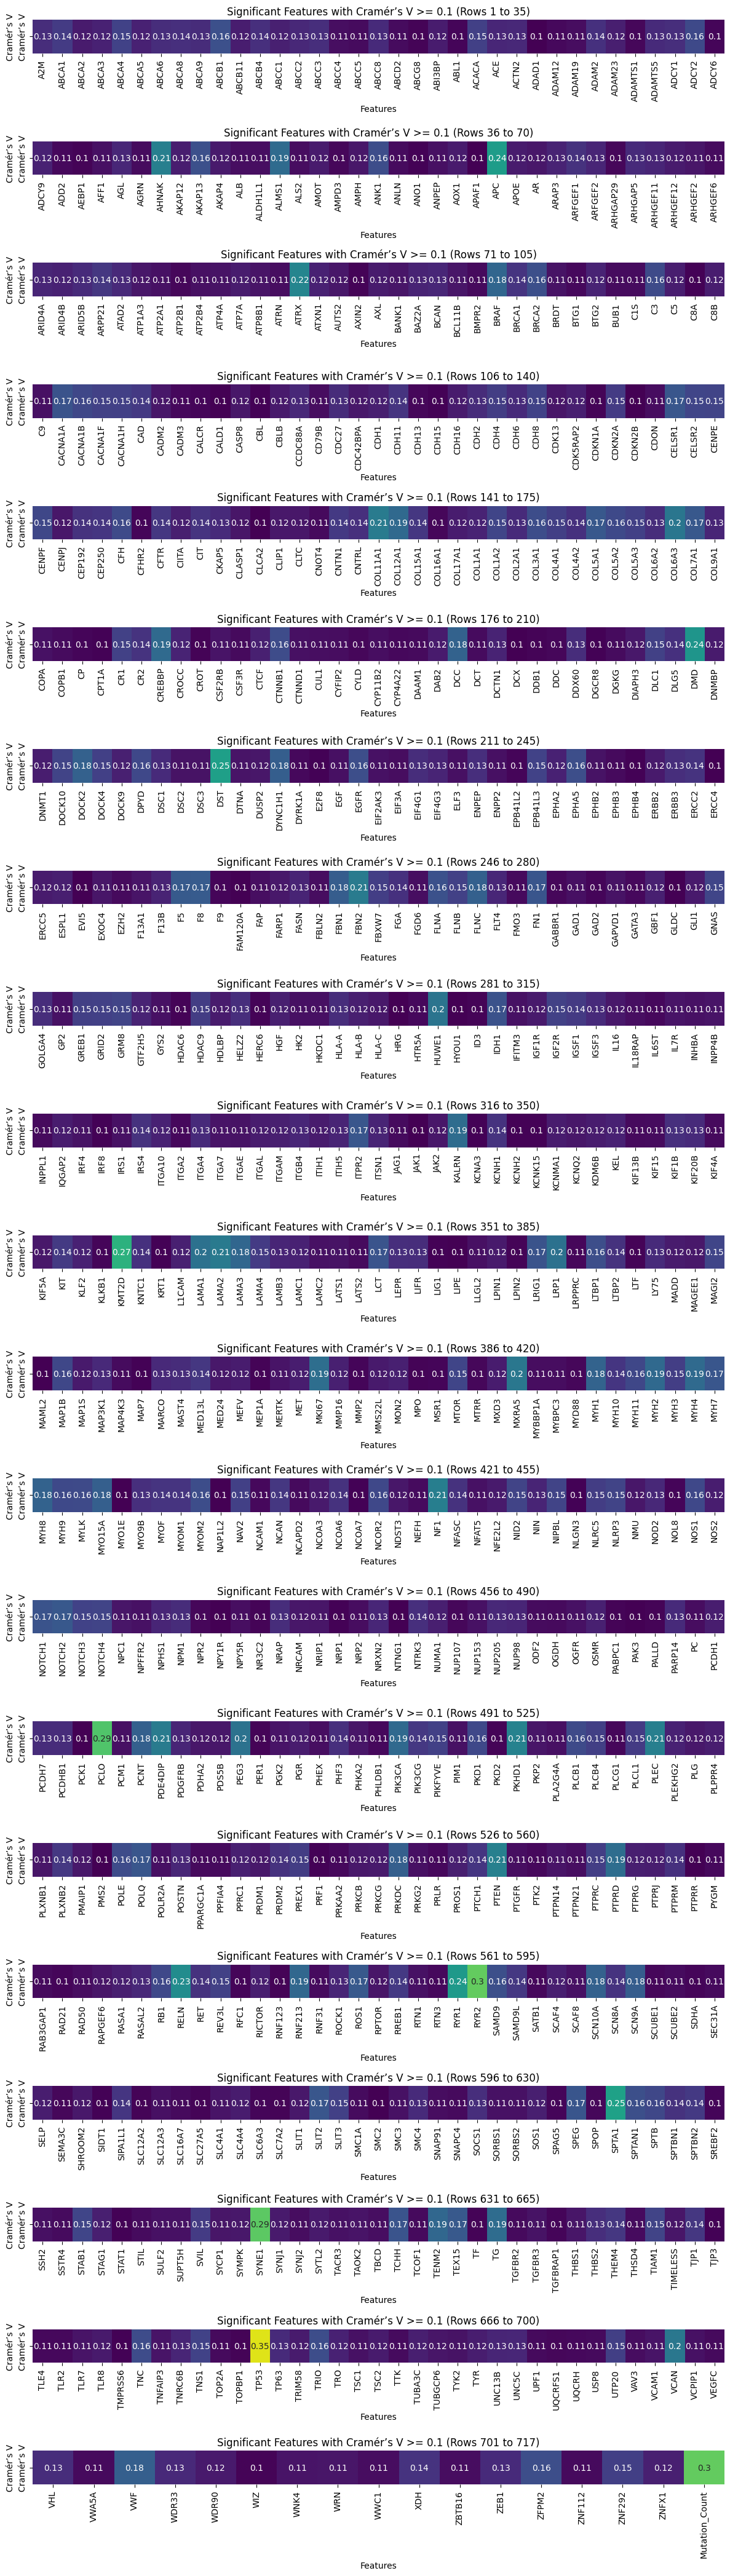

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Cramér's V 값이 0.1 ~ 0.36 사이로 색상 범위를 조정
cmap = sns.color_palette("viridis", as_cmap=True)
norm = plt.Normalize(vmin=0.1, vmax=0.36)


# 필터링된 피처의 Cramér's V 값을 한 줄에 35개씩 나누어 시각화
if not significant_features_df.empty:
    # 데이터프레임을 10개씩 나누어 리스트로 변환
    num_features_per_row = 35
    num_rows = int(np.ceil(len(significant_features_df) / num_features_per_row))

    plt.figure(figsize=(12, num_rows * 2))  # 높이는 필터링된 피처의 수에 따라 조절

    for i in range(num_rows):
        start_idx = i * num_features_per_row
        end_idx = min((i + 1) * num_features_per_row, len(significant_features_df))

        # 데이터 슬라이스
        subset_df = significant_features_df.iloc[start_idx:end_idx]

        # 각 슬라이스에 대한 heatmap 그리기
        plt.subplot(num_rows, 1, i + 1)
        sns.heatmap(subset_df.T, annot=True, cmap='viridis', norm=norm, vmin=0, vmax=1, cbar=False)
        plt.title(f'Significant Features with Cramér’s V >= 0.1 (Rows {start_idx+1} to {end_idx})')
        plt.xlabel('Features')
        plt.ylabel('Cramér’s V')

    plt.tight_layout()
    plt.show()
else:
    print("No features with Cramér’s V >= 0.1 found.")